## Poisson en 2D con condiciones de frontera de Dirichlet

En este notebook, resolveremos la ecuación de Poisson en 2D con condiciones de frontera de Dirichlet. La ecuación de Poisson se utiliza para describir fenómenos de potencial, como el campo eléctrico y el campo gravitacional, en un dominio espacial.

La ecuación de Poisson en 2D está dada por:

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x, y), \quad (x, y) \in \Omega $$

donde $ \Omega = [0, 1] \times [0, 1] $ y $ f(x, y) $ es el término fuente.

Las condiciones de frontera son:

$$ u(x, y) = 0, \quad (x, y) \in \partial \Omega $$

El término fuente $ f(x, y) $ está definido como:

$$ f(x, y) = -32 \left[ (1 - y) y + (1 - x) x \right] $$

La solución exacta de la ecuación es:

$$ u(x, y) = 16 (1 - x) x (1 - y) y $$

En este notebook, utilizaremos el método de diferencias finitas para resolver numéricamente esta ecuación y compararemos la solución numérica con la solución exacta.

In [2]:
from devito import Grid, Function,TimeFunction, Eq, Operator, configuration, Eq, solve # Importing necessary functions from Devito
import numpy as np # Importing NumPy
import matplotlib.pyplot as plt # Importing Matplotlib

In [3]:
# Parameters
nx = 200  # Number of grid points in the x direction
ny = 200  # Number of grid points in the y direction
nt = int(1e+5)  # Number of time steps (not used in this static problem)
xmin = 0.  # Minimum x value
ymin = 0.  # Minimum y value
xmax = 1.  # Maximum x value
ymax = 1.  # Maximum y value
extent = (xmin, xmax, ymin, ymax)  # Extent of the grid

# Increase the space order for higher accuracy
space_order = 2

# Silence the runtime performance logging
configuration['log-level'] = 'ERROR'

# Create the grid
grid = Grid(shape=(nx, ny), extent=(xmax, ymax))
x, y = grid.dimensions
t = grid.stepping_dim

In [4]:
# Now with Devito we will turn `p` into a `TimeFunction` object 
# to make all the buffer switching implicit
p = TimeFunction(name='p', grid=grid, space_order=space_order)

# Initialize the data of `p` to zero
p.data[:] = 0.

In [5]:
# Initialise the source term `b`
b = Function(name='b', grid=grid)
b.data[:] = 0.

# Generate the x and y values for the grid
x_vals = np.linspace(xmin, xmax, nx)
y_vals = np.linspace(ymin, ymax, ny)

# Create a meshgrid for the x and y values
X, Y = np.meshgrid(x_vals, y_vals)

# Define the source term `b` using the given formula
b.data[:] = -32 * ((1 - Y) * Y + (1 - X) * X)

In [6]:
# Create the Laplace equation based on `p`
eq = Eq(p.laplace, b)

# Let SymPy solve for the central stencil point
stencil = solve(eq, p)

# Let our stencil populate the buffer `p.forward`
eq_stencil = Eq(p.forward, stencil)

# Display the stencil equation
eq_stencil

Eq(p(t + dt, x, y), -0.5*(h_x**2*h_y**2*b(x, y) - h_x**2*p(t, x, y - h_y) - h_x**2*p(t, x, y + h_y) - h_y**2*p(t, x - h_x, y) - h_y**2*p(t, x + h_x, y))/(h_x**2 + h_y**2))

In [7]:
# Create the boundary conditions
# p = 0 at y = ymin
bc = [Eq(p[t + 1, x, 0], 0.)]

# p = 0 at y = ymax
bc += [Eq(p[t + 1, x, ny-1], 0.)]

# p = 0 at x = xmin
bc += [Eq(p[t + 1, 0, y], 0.)]

# p = 0 at x = xmax
bc += [Eq(p[t + 1, nx-1, y], 0.)]

In [8]:
# Set the log level to 'ERROR' to reduce verbosity
configuration['log-level'] = 'ERROR'

# Create and execute the operator for a number of timesteps
op = Operator([eq_stencil] + bc)

# Measure the execution time of the operator
%time op(time=nt)

CPU times: user 597 ms, sys: 0 ns, total: 597 ms
Wall time: 601 ms


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.5770879999996944, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0028820000000000564, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

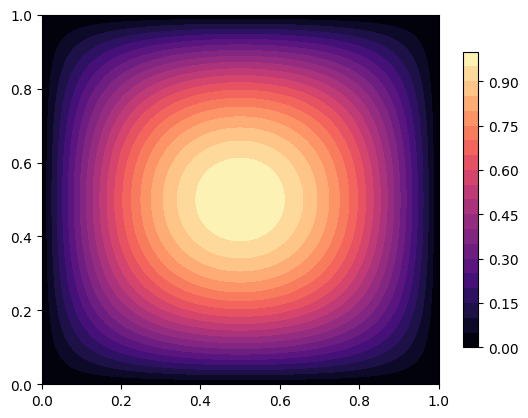

In [12]:
# Plot the numerical solution at the initial time step
plt.contourf(p.data[0], cmap='magma', extent=extent, levels=20)

# Add a colorbar to the plot
plt.colorbar(shrink=0.8)

# Display the plot
plt.show()

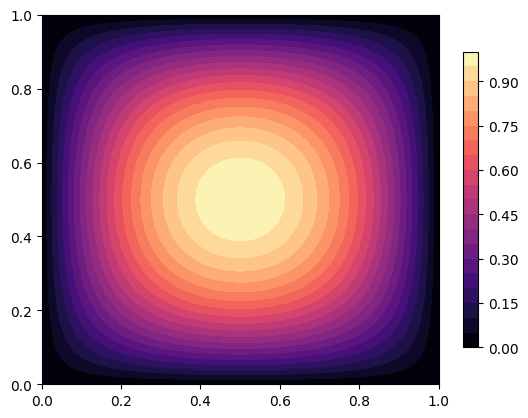

In [13]:
# Calculate the exact solution
u_exact = 16 * (1 - X) * X * (1 - Y) * Y

# Plot the exact solution
plt.contourf(u_exact, cmap='magma', extent=extent, levels=20)

# Add a colorbar to the plot
plt.colorbar(shrink=0.8)

# Display the plot
plt.show()

In [14]:
# Calculate the relative error
error = np.linalg.norm(p.data[nt].flatten() - u_exact.flatten()) / np.linalg.norm(u_exact.flatten())

# Print the relative error norm
print('Relative error norm: %.5f' % error)

Relative error norm: 0.00018
